In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve


In [2]:
read_in_df = pd.read_csv('../Data/expanded_clean.csv', index_col=0)
main_df = read_in_df.copy()
transformed_df = pd.DataFrame()

In [3]:
main_df.head(5)

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


# Data Cleaning
Convert columns to booleans where appropriate

In [4]:
main_df['bruises?'].unique()

array(['BRUISES', 'NO'], dtype=object)

In [5]:
# Bruises? is a binary variable (BRUISES/NO) so we can convert it to a boolean
transformed_df['bruises?'] = main_df['bruises?'] == 'BRUISES'

In [6]:
ring_number_map = {"ONE": 1, "TWO": 2, "NONE": 0}
transformed_df['ring-number'] = main_df['ring-number'].map(ring_number_map)

In [7]:
# Print out the unique values for each column
for col in main_df.columns:
    print(col, main_df[col].unique())
    

class ['EDIBLE' 'POISONOUS']
cap-shape ['CONVEX' 'FLAT' 'BELL' 'SUNKEN' 'KNOBBED' 'CONICAL']
cap-surface ['SMOOTH' 'FIBROUS' 'SCALY' 'GROOVES']
cap-color ['WHITE' 'YELLOW' 'BROWN' 'GRAY' 'RED' 'PINK' 'PURPLE' 'GREEN' 'BUFF'
 'CINNAMON']
bruises? ['BRUISES' 'NO']
odor ['ALMOND' 'ANISE' 'NONE' 'PUNGENT' 'CREOSOTE' 'FOUL' 'FISHY' 'SPICY'
 'MUSTY']
gill-attachment ['FREE' 'ATTACHED']
gill-spacing ['CROWDED' 'CLOSE']
gill-size ['NARROW' 'BROAD']
gill-color ['WHITE' 'PINK' 'BROWN' 'GRAY' 'BLACK' 'CHOCOLATE' 'PURPLE' 'GREEN' 'RED'
 'BUFF' 'YELLOW' 'ORANGE']
stalk-shape ['TAPERING' 'ENLARGING']
stalk-root ['BULBOUS' 'CLUB' 'ROOTED' 'EQUAL' '?']
stalk-surface-above-ring ['SMOOTH' 'FIBROUS' 'SILKY' 'SCALY']
stalk-surface-below-ring ['SMOOTH' 'SCALY' 'FIBROUS' 'SILKY']
stalk-color-above-ring ['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'CINNAMON' 'YELLOW' 'ORANGE']
stalk-color-below-ring ['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'YELLOW' 'CINNAMON' 'ORANGE']
veil-type ['PARTIAL']
veil-color ['WH

In [8]:
transformed_df['poisonous'] = main_df['class'] == 'POISONOUS'

In [9]:
non_categorical = set(['poisionous', 'bruises?', 'ring-number', 'class'])
categorical = set(main_df.columns) - non_categorical

In [10]:
# Generate dummmy variables for each of the categorical variables
for col in categorical:
    transformed_df = pd.concat([transformed_df, 
                                pd.get_dummies(main_df[col], prefix=col, drop_first=True)], 
                                axis=1)

In [11]:
# Print data about the dataset
print(f'Number of rows: {len(main_df)}')
print(f'Number of columns: {len(main_df.columns)}')
print(f'Number of poisonous mushrooms: {len(main_df[transformed_df["poisonous"]])}')
print(f'Number of edible mushrooms: {len(main_df[~transformed_df["poisonous"]])}')

Number of rows: 8416
Number of columns: 23
Number of poisonous mushrooms: 3928
Number of edible mushrooms: 4488


In [12]:
# Print all rows of the dataset
pd.set_option('display.max_rows', None)
main_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,...,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,...,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


In [13]:
# Print number of rows with missing values (NaN or '?')
# Convert '?' to NaN
main_df = main_df.replace('?', np.nan)
# Print columns with missing values and the number of missing values
print("Columns with missing values and number of missing values:")
print(main_df.isnull().sum()[main_df.isnull().sum() > 0])

Columns with missing values and number of missing values:
stalk-root    2480
dtype: int64


<AxesSubplot:>

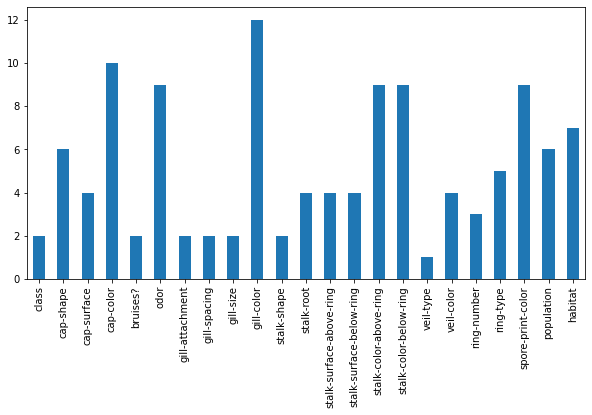

In [14]:
# make a bar plot of the number of unique values in each column
main_df.nunique().plot(kind='bar', figsize=(10, 5))

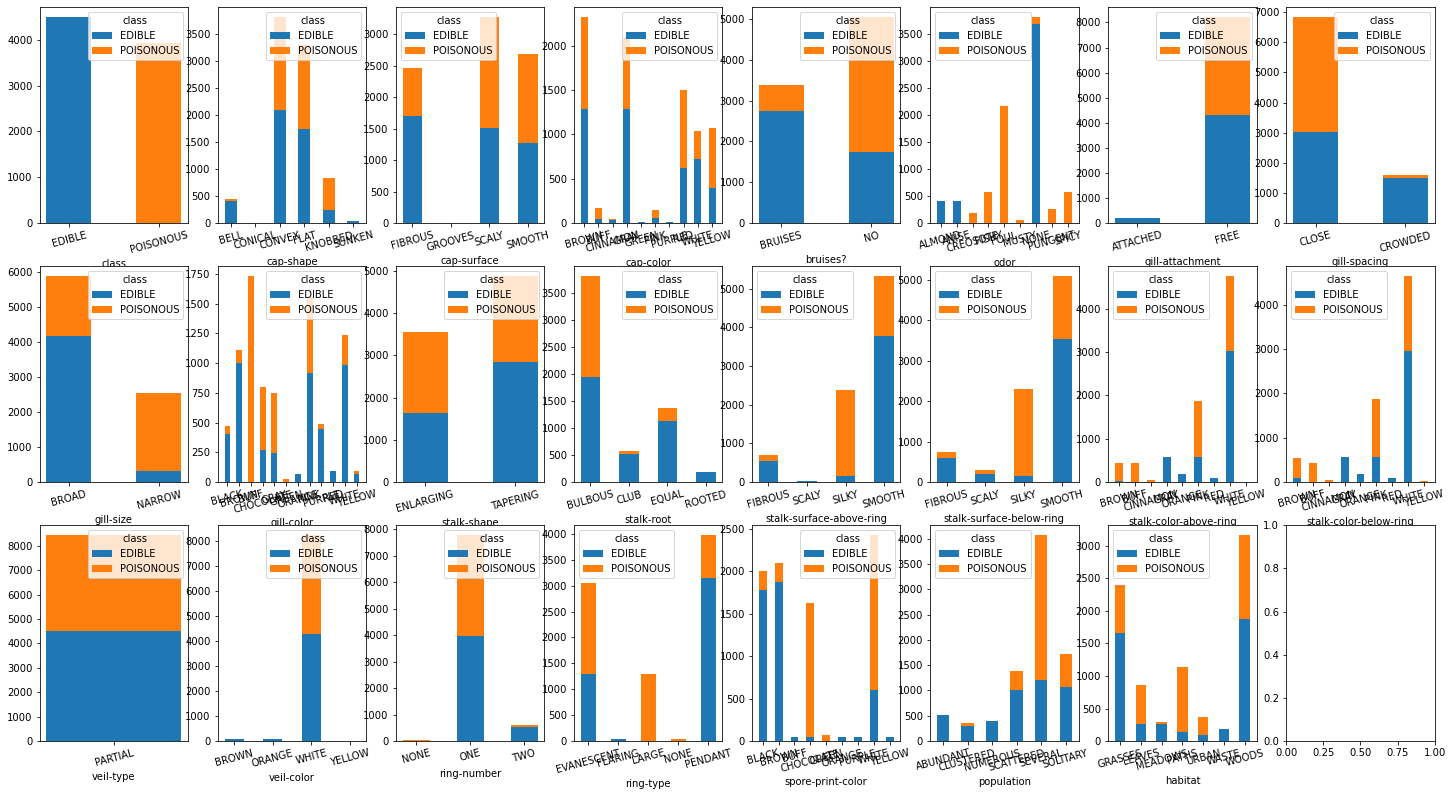

In [15]:
# Make a bar plot of the distribution of unique values for each column
# Within each bar, poisonous mushrooms are shown in red, while edible mushrooms are shown in blue
# Stack the bars on top of each other

num_cols = len(main_df.columns)

num_graph_cols = 8
num_graph_rows = int(np.ceil(num_cols / num_graph_cols))

fig, axs = plt.subplots(num_graph_rows, num_graph_cols, figsize=(25, num_graph_rows * 4.5))

for col in main_df.columns:
    main_df.groupby(col)['class'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axs.flat[main_df.columns.get_loc(col)])
    # turn the axis labels 45 degrees
    axs.flat[main_df.columns.get_loc(col)].tick_params(axis='x', rotation=15)
    # Set axes tight
    axs.flat[main_df.columns.get_loc(col)].axis('tight')

In [17]:
main_df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [56]:
# Print the distribution of poisonous and edible mushrooms and their percentages
print("Distribution of poisonous and edible mushrooms:")
dist_df = main_df['class'].value_counts()
# add percentages
dist_df = pd.concat([dist_df, dist_df / len(main_df) * 100], axis=1)
dist_df.columns = ['count', 'percentage']
dist_df

Distribution of poisonous and edible mushrooms:


,count,percentage
EDIBLE,4488,53.326996
POISONOUS,3928,46.673004


## Odor analysis
Appears that odor will be a strong predictor

In [145]:
main_df['odor'].value_counts()

NONE        3808
FOUL        2160
FISHY        576
SPICY        576
ALMOND       400
ANISE        400
PUNGENT      256
CREOSOTE     192
MUSTY         48
Name: odor, dtype: int64

In [147]:
# For each odor value, print the number of poisonous and edible mushrooms
main_df.groupby('odor')['class'].value_counts()

odor      class    
ALMOND    EDIBLE        400
ANISE     EDIBLE        400
CREOSOTE  POISONOUS     192
FISHY     POISONOUS     576
FOUL      POISONOUS    2160
MUSTY     POISONOUS      48
NONE      EDIBLE       3688
          POISONOUS     120
PUNGENT   POISONOUS     256
SPICY     POISONOUS     576
Name: class, dtype: int64

According to the above figure, mushrooms with almond or anise odors will always be edible. Mushrooms with no odor tend to be edible. All other odors tend to be poisonous. This is a strong predictor.